<a href="https://colab.research.google.com/github/trainsn/cuda-learning/blob/master/udacity_cs344_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Homework 4 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/depctg/udacity-cs344-colab
!pip install git+git://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "udacity-cs344-colab/src/HW4"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir udacity-cs344-colab/build
%cd udacity-cs344-colab/build
!cmake ../src

Cloning into 'udacity-cs344-colab'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 3.93 MiB | 7.01 MiB/s, done.
Resolving deltas: 100% (43/43), done.
  Cloning git://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-ydj815al
  Running command git clone -q git://github.com/depctg/nvcc4jupyter.git /tmp/pip-req-build-ydj815al
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4334 sha256=79816bd5304fc896661eb63f538de0cde9064e233f3201c25dbaa1508eeee931
  Stored in directory: /tmp/pip-ephem-wheel-cache-leat2hlf/wheels/1e/43/2d/099cad2b9b02dfa88573f50a22735d8a0b2ba69bf82167b81c
Successfully built NVCCPlugin
Set up cuda environment at /content/udacity-cs344-colab/src/HW4
Default out bin result.out
/content/udacity-cs344-colab/build
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/b

In [0]:
%%cuda --name student_func.cu

//Udacity HW 4
//Radix Sorting

#include "utils.h"
#include <thrust/host_vector.h>

/* Red Eye Removal
   ===============

   For this assignment we are implementing red eye removal.  This is
   accomplished by first creating a score for every pixel that tells us how
   likely it is to be a red eye pixel.  We have already done this for you - you
   are receiving the scores and need to sort them in ascending order so that we
   know which pixels to alter to remove the red eye.

   Note: ascending order == smallest to largest

   Each score is associated with a position, when you sort the scores, you must
   also move the positions accordingly.

   Implementing Parallel Radix Sort with CUDA
   ==========================================

   The basic idea is to construct a histogram on each pass of how many of each
   "digit" there are.   Then we scan this histogram so that we know where to put
   the output of each digit.  For example, the first 1 must come after all the
   0s so we have to know how many 0s there are to be able to start moving 1s
   into the correct position.

   1) Histogram of the number of occurrences of each digit
   2) Exclusive Prefix Sum of Histogram
   3) Determine relative offset of each digit
        For example [0 0 1 1 0 0 1]
                ->  [0 1 0 1 2 3 2]
   4) Combine the results of steps 2 & 3 to determine the final
      output location for each element and move it there

   LSB Radix sort is an out-of-place sort and you will need to ping-pong values
   between the input and output buffers we have provided.  Make sure the final
   sorted results end up in the output buffer!  Hint: You may need to do a copy
   at the end.

 */

int get_max_size(int n, int d){
  return (int)ceil((float)n/(float)d) + 1; 
}

__global__
void histogram_kernel(unsigned int pass,
          unsigned int* d_bins,
          unsigned int* const d_input, 
          unsigned int size)
{
  int mid = threadIdx.x + blockDim.x * blockIdx.x;
  if (mid >= size)
    return;
 
  int bin = (d_input[mid] >> pass) & 1u;
  if (bin)
    atomicAdd(&d_bins[1], 1);
  else 
    atomicAdd(&d_bins[0], 1);
} 

// we will run 1 exclusive scan, but then when we 
// do the move, for zero vals, we will take mid - val of scan there
__global__
void exclusive_scan_kernel(unsigned int pass,
              unsigned int const* d_inputVals,
              unsigned int* d_output,
              const int size,
              unsigned int base,
              unsigned int threadSize)
{
  int mid = threadIdx.x + threadSize * base; 
  int block = threadSize * base;
  
  if (mid >= size)
    return;
  unsigned int val = 0;
  if (mid > 0)
    val = (d_inputVals[mid - 1] >> pass) & 1u;
  else 
    val = 0;
 
  d_output[mid] = val;

  __syncthreads();
 
  for (int s = 1; s <= threadSize; s *= 2){
      int spot = mid - s;

      if (spot >= 0 && spot >= threadSize * base)
        val = d_output[spot];
      __syncthreads();
      if (spot >= 0 && spot >= threadSize * base)
        d_output[mid] += val;
      __syncthreads();
  }
  if (base > 0)
    d_output[mid] += d_output[base * threadSize - 1]; 
}

__global__ 
void move_kernel(
    unsigned int pass,
    unsigned int* const d_inputVals,
    unsigned int* const d_inputPos,
    unsigned int* d_outputVals,
    unsigned int* d_outputPos,
    unsigned int* const d_scanned,
    unsigned int one_pos,
    const size_t numElems)
{
  int mid = threadIdx.x + blockDim.x * blockIdx.x;
  if (mid >= numElems)
    return;
 
  unsigned int scan = 0;
  unsigned int base = 0;
  if ((d_inputVals[mid] >> pass) & 1u){
      scan = d_scanned[mid];
      base = one_pos;
  } else {
      scan = mid - d_scanned[mid];
      base = 0;
  }
 
  d_outputPos[base+scan] = d_inputPos[mid];
  d_outputVals[base+scan] = d_inputVals[mid];
}


void your_sort(unsigned int* const d_inputVals,
               unsigned int* const d_inputPos,
               unsigned int* const d_outputVals,
               unsigned int* const d_outputPos,
               const size_t numElems)
{
  //PUT YOUR SORT HERE
  unsigned int* d_bins;
  unsigned int h_bins[2];
  unsigned int* d_scanned;
  unsigned int* d_moved;
 
  const size_t histo_size = 2 * sizeof(unsigned int);
  const size_t arr_size = numElems * sizeof(unsigned int);
 
  checkCudaErrors(cudaMalloc(&d_bins, histo_size));
  checkCudaErrors(cudaMalloc(&d_scanned, arr_size));
  checkCudaErrors(cudaMalloc(&d_moved, arr_size));
 
  dim3 thread_dim(1024);
  dim3 hist_block_dim(get_max_size(numElems, thread_dim.x));
 
  for (unsigned int pass = 0; pass < 32; pass++){
      checkCudaErrors(cudaMemset(d_bins, 0, histo_size));
      checkCudaErrors(cudaMemset(d_scanned, 0, arr_size));
      checkCudaErrors(cudaMemset(d_outputVals, 0, arr_size));
      checkCudaErrors(cudaMemset(d_outputPos, 0, arr_size));

      histogram_kernel<<<hist_block_dim, thread_dim>>>(pass, d_bins, d_inputVals, numElems);
      cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

      // copy the histogram data to host 
      checkCudaErrors(cudaMemcpy(&h_bins, d_bins, histo_size, cudaMemcpyDeviceToHost));

      printf("%d %d %d %d %d\n", h_bins[0], h_bins[1], h_bins[0]+h_bins[1], numElems, pass);

      // have 0 and 1 start positions 
      // get the scan of 1's
      for (int i = 0; i < get_max_size(numElems, thread_dim.x); i++){
          exclusive_scan_kernel<<<dim3(1), thread_dim>>>(
            pass,
            d_inputVals,
            d_scanned,
            numElems,
            i,
            thread_dim.x
          ); 
          cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());
      }       

      // calculate the move positions
      move_kernel<<<hist_block_dim, thread_dim>>>(
          pass,
          d_inputVals,
          d_inputPos,
          d_outputVals,
          d_outputPos,
          d_scanned,
          h_bins[0],
          numElems
      );
      cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

      // copy the histogram data to input 
      checkCudaErrors(cudaMemcpy(d_inputVals, d_outputVals, arr_size, cudaMemcpyDeviceToDevice));
      checkCudaErrors(cudaMemcpy(d_inputPos, d_outputPos, arr_size, cudaMemcpyDeviceToDevice));

      cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());
  }
 
  checkCudaErrors(cudaFree(d_scanned));
  checkCudaErrors(cudaFree(d_bins));
}

'File written in /content/udacity-cs344-colab/src/HW4/student_func.cu'

In [0]:
# make the cuda project
!make HW4
print("\n====== RESULT OF HW4 =======\n")
!bin/HW4 ../src/HW4/red_eye_effect.gold ../src/HW4/red_eye_effect_template_5.jpg

[ 14%] Building NVCC (Device) object HW4/CMakeFiles/HW4.dir/HW4_generated_student_func.cu.o
/content/udacity-cs344-colab/src/HW4/student_func.cu(78): warning: variable "block" was declared but never referenced

/content/udacity-cs344-colab/src/HW4/student_func.cu(78): warning: variable "block" was declared but never referenced

/content/udacity-cs344-colab/src/HW4/student_func.cu: In function ‘void your_sort(unsigned int*, unsigned int*, unsigned int*, unsigned int*, size_t)’:
/content/udacity-cs344-colab/src/HW4/student_func.cu:170:91: warning: format ‘%d’ expects argument of type ‘int’, but argument 5 has type ‘size_t {aka long unsigned int}’ [-Wformat=]
       printf("%d %d %d %d %d\n", h_bins[0], h_bins[1], h_bins[0]+h_bins[1], numElems, pass);
                                                                                           ^
[ 28%] Linking CXX executable ../bin/HW4
[100%] Built target HW4

====== RESULT OF HW4 =======

118854 101626 220480 220480 0
110087 110393 220480 2

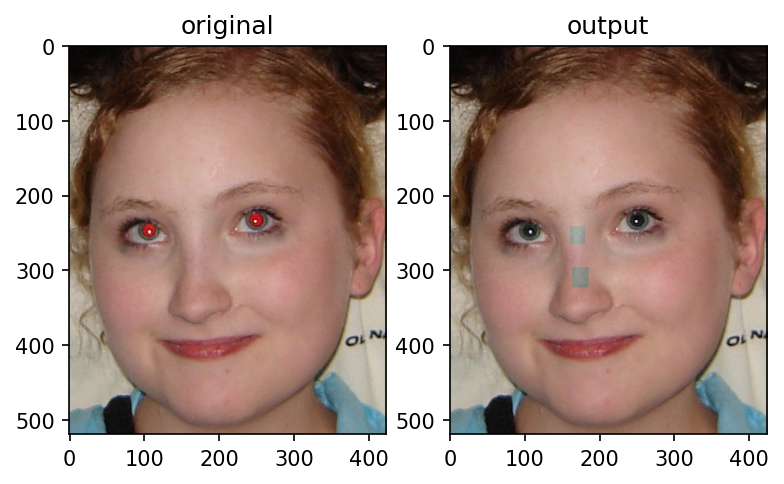

In [0]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(1,2, dpi=150)

ax[0].imshow(plt.imread("../src/HW4/red_eye_effect_5.jpg"))
ax[0].set_title("original")
ax[0].grid(False)

ax[1].imshow(plt.imread("HW4_output.png"))
ax[1].set_title("output")
ax[1].grid(False)

plt.show()